# Assignment 1
### Pavlo Khomenko

In [23]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython.display import display

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

print("Libraries imported successfully")

Libraries imported successfully


---
# Section 1: Data Loading

In [24]:
con = duckdb.connect(database=':memory:')

In [25]:
query_load = """
CREATE TABLE recipes_raw AS
SELECT *
FROM read_json_auto('2_Recipe_json.json', 
                    format='newline_delimited',
                    maximum_object_size=10000000);
"""

con.execute(query_load)
print("Data loaded successfully into recipes_raw table")

Data loaded successfully into recipes_raw table


In [26]:
row_count = con.execute("SELECT COUNT(*) as count FROM recipes_raw").fetchone()[0]
print(f"Total recipes loaded: {row_count:,}")

schema_df = con.execute("DESCRIBE recipes_raw").df()
print("\nTable Schema:")
display(schema_df)

Total recipes loaded: 62,126

Table Schema:


,column_name,column_type,null,key,default,extra
0,recipe_title,VARCHAR,YES,None,None,None
1,category,VARCHAR,YES,None,None,None
2,subcategory,VARCHAR,YES,None,None,None
3,description,VARCHAR,YES,None,None,None
4,ingredients,VARCHAR[],YES,None,None,None
5,directions,VARCHAR[],YES,None,None,None
6,num_ingredients,BIGINT,YES,None,None,None
7,num_steps,BIGINT,YES,None,None,None


In [27]:
sample_df = con.execute("""
    SELECT recipe_title, category, num_ingredients, num_steps, 
           SUBSTRING(description, 1, 100) || '...' as description_preview
    FROM recipes_raw 
    LIMIT 10
""").df()

print("\nSample Data (First 10 Recipes):")
display(sample_df)


Sample Data (First 10 Recipes):


,recipe_title,category,num_ingredients,num_steps,description_preview
0,Air Fryer Potato Slices with Dipping Sauce,Air Fryer Recipes,9,5,"These air fryer potato slices, served with a beer ketchup dipping sauce, are a tasty finger food..."
1,Gochujang Pork Belly Bites,Air Fryer Recipes,5,4,"These gochujang pork belly bites are sweet and spicy, crispy and crunchy, and absolutely delicio..."
2,3-Ingredient Air Fryer Everything Bagel Chicken Strips,Air Fryer Recipes,3,4,"These 3-ingredient air fryer everything bagel chicken strips are simple, flavorful, and deliciou..."
3,Air Fryer Everything Bagel Chicken Cutlets,Air Fryer Recipes,9,9,"These air fryer everything bagel chicken cutlets, breaded with everything-seasoned panko breadcr..."
4,Air Fryer Honey Sriracha Salmon Bites,Air Fryer Recipes,5,5,"These air fryer honey Sriracha salmon bites are cubes of salmon, lightly seasoned with salt, pep..."
5,Air Fryer Corn on The Cob,Air Fryer Recipes,6,4,Air fryer corn on the cob is super quick to make and full of sweet roasted corn flavor. I like t...
6,Air Fryer Peanut Chicken,Air Fryer Recipes,13,7,"In this air fryer peanut chicken recipe, boneless, skinless chicken thighs are marinated in a sp..."
7,Air Fryer Crispy Onions,Air Fryer Recipes,5,3,"These air fryer crispy onions are delicious over steaks, in burgers, or just as a side dish, plu..."
8,Air Fryer Hot Honey Glazed Carrots,Air Fryer Recipes,4,3,"These air fryer hot honey glazed carrots are a delicious side dish, and so easy to make, with on..."
9,Air Fryer Sauteed Onions,Air Fryer Recipes,3,3,"Air fryer sauteed onions add a lot to burgers, sandwiches, tacos, fajitas, or even rice or mashe..."


---
# Section 2: Data Parsing & Transformation

## 2.1 Create Main Recipes Table

In [28]:
con.execute("""
  CREATE TABLE recipes AS
  SELECT 
      ROW_NUMBER() OVER () as recipe_id,
      CAST(recipe_title AS VARCHAR) as recipe_title,
      CAST(category AS VARCHAR) as category,
      CAST(subcategory AS VARCHAR) as subcategory,
      CAST(description AS VARCHAR) as description,
      CAST(num_ingredients AS INTEGER) as num_ingredients,
      CAST(num_steps AS INTEGER) as num_steps,
      LENGTH(description) as description_length
  FROM recipes_raw;
  """)
print("Main recipes table created")

recipes_count = con.execute("SELECT COUNT(*) FROM recipes").fetchone()[0]
print(f"Total recipes in normalized table: {recipes_count:,}")

display(con.execute("SELECT * FROM recipes LIMIT 5").df())

Main recipes table created
Total recipes in normalized table: 62,126


,recipe_id,recipe_title,category,subcategory,description,num_ingredients,num_steps,description_length
0,1,Air Fryer Potato Slices with Dipping Sauce,Air Fryer Recipes,Air Fryer Recipes,"These air fryer potato slices, served with a beer ketchup dipping sauce, are a tasty finger food...",9,5,204
1,2,Gochujang Pork Belly Bites,Air Fryer Recipes,Air Fryer Recipes,"These gochujang pork belly bites are sweet and spicy, crispy and crunchy, and absolutely delicio...",5,4,236
2,3,3-Ingredient Air Fryer Everything Bagel Chicken Strips,Air Fryer Recipes,Air Fryer Recipes,"These 3-ingredient air fryer everything bagel chicken strips are simple, flavorful, and deliciou...",3,4,369
3,4,Air Fryer Everything Bagel Chicken Cutlets,Air Fryer Recipes,Air Fryer Recipes,"These air fryer everything bagel chicken cutlets, breaded with everything-seasoned panko breadcr...",9,9,168
4,5,Air Fryer Honey Sriracha Salmon Bites,Air Fryer Recipes,Air Fryer Recipes,"These air fryer honey Sriracha salmon bites are cubes of salmon, lightly seasoned with salt, pep...",5,5,332


## 2.2 Flatten Ingredients Array

In [29]:
con.execute("""
  CREATE TABLE recipes_ingredients AS
  WITH deduplicated_raw AS (
      SELECT 
          recipe_title,
          ingredients,
          ROW_NUMBER() OVER (PARTITION BY recipe_title ORDER BY (SELECT NULL)) as rn
      FROM recipes_raw
  )
  SELECT 
      r.recipe_id,
      r.recipe_title,
      r.category,
      ROW_NUMBER() OVER (PARTITION BY r.recipe_id ORDER BY (SELECT NULL)) as ingredient_position,
      UNNEST(dr.ingredients) as ingredient_text
  FROM recipes r
  JOIN deduplicated_raw dr ON r.recipe_title = dr.recipe_title AND dr.rn = 1;
  """)


ing_count = con.execute("SELECT COUNT(*) FROM recipes_ingredients").fetchone()[0]
print(f"Total ingredient entries: {ing_count:,}")

sample_ing = con.execute("""
    SELECT recipe_id, recipe_title, ingredient_position, ingredient_text
    FROM recipes_ingredients
    WHERE recipe_id = 1
""").df()

print("\nSample: Ingredients for Recipe #1")
display(sample_ing)

Total ingredient entries: 560,292

Sample: Ingredients for Recipe #1


,recipe_id,recipe_title,ingredient_position,ingredient_text
0,1,Air Fryer Potato Slices with Dipping Sauce,1,3/4 cup ketchup
1,1,Air Fryer Potato Slices with Dipping Sauce,1,1/2 cup beer
2,1,Air Fryer Potato Slices with Dipping Sauce,1,1 tablespoon Worcestershire sauce
3,1,Air Fryer Potato Slices with Dipping Sauce,1,1/2 teaspoon onion powder
4,1,Air Fryer Potato Slices with Dipping Sauce,1,1/4 teaspoon cayenne
5,1,Air Fryer Potato Slices with Dipping Sauce,1,2 baking potatoes
6,1,Air Fryer Potato Slices with Dipping Sauce,1,olive oil cooking spray
7,1,Air Fryer Potato Slices with Dipping Sauce,1,1/2 teaspoon garlic powder
8,1,Air Fryer Potato Slices with Dipping Sauce,1,salt and freshly ground black pepper


## 2.3 Flatten Directions Array

In [30]:
con.execute("""
  CREATE TABLE recipes_directions AS
  WITH deduplicated_raw AS (
      SELECT 
          recipe_title,
          directions,
          ROW_NUMBER() OVER (PARTITION BY recipe_title ORDER BY (SELECT NULL)) as rn
      FROM recipes_raw
  )
  SELECT 
      r.recipe_id,
      r.recipe_title,
      r.category,
      ROW_NUMBER() OVER (PARTITION BY r.recipe_id ORDER BY (SELECT NULL)) as dir_position,
      UNNEST(dr.directions) as dir_text
  FROM recipes r
  JOIN deduplicated_raw dr ON r.recipe_title = dr.recipe_title AND dr.rn = 1;
  """)

print("Directions table created")

dir_count = con.execute("SELECT COUNT(*) FROM recipes_directions").fetchone()[0]
print(f"Total direction steps: {dir_count:,}")

sample_dir = con.execute("""
    SELECT recipe_id, recipe_title, dir_position, dir_text
    FROM recipes_directions
    WHERE recipe_id = 1
""").df()

print("\nSample: Directions for Recipe #1")
display(sample_dir)

Directions table created
Total direction steps: 289,646

Sample: Directions for Recipe #1


,recipe_id,recipe_title,dir_position,dir_text
0,1,Air Fryer Potato Slices with Dipping Sauce,1,"Combine ketchup, beer, Worcestershire sauce, onion powder, and cayenne in a small saucepan. Brin..."
1,1,Air Fryer Potato Slices with Dipping Sauce,1,Preheat the air fryer to 400 degrees F (200 degrees C). Spray the basket with cooking spray or l...
2,1,Air Fryer Potato Slices with Dipping Sauce,1,"Slice potatoes 1/4-inch thick (use a mandoline if you have one), and place in a bowl. Spray pota..."
3,1,Air Fryer Potato Slices with Dipping Sauce,1,"Place potatoes in a single layer in the air fryer, and cook, shaking occasionally, until they st..."
4,1,Air Fryer Potato Slices with Dipping Sauce,1,"Remove from the fryer, and serve with beer ketchup dipping sauce."


## 2.4 Summary of Parsed Data

In [31]:
tables_df = con.execute("SHOW TABLES").df()
print("\nDatabase Tables:")
display(tables_df)

summary = con.execute("""
    SELECT 
        'Recipes' as table_name,
        COUNT(*) as row_count
    FROM recipes
    UNION ALL
    SELECT 
        'Ingredients',
        COUNT(*)
    FROM recipes_ingredients
    UNION ALL
    SELECT 
        'Directions',
        COUNT(*)
    FROM recipes_directions
""").df()

print("\nData Parsing Summary:")
display(summary)


Database Tables:


,name
0,recipes
1,recipes_directions
2,recipes_ingredients
3,recipes_raw



Data Parsing Summary:


,table_name,row_count
0,Recipes,62126
1,Ingredients,560292
2,Directions,289646


---
# Section 3: Data Quality Checks

## 3.1 Null Value Analysis

In [32]:
null_check_query = """
SELECT 
    COUNT(*) as total_recipes,
    SUM(CASE WHEN recipe_title IS NULL THEN 1 ELSE 0 END) as null_title,
    SUM(CASE WHEN category IS NULL THEN 1 ELSE 0 END) as null_category,
    SUM(CASE WHEN subcategory IS NULL THEN 1 ELSE 0 END) as null_subcategory,
    SUM(CASE WHEN description IS NULL THEN 1 ELSE 0 END) as null_description,
    SUM(CASE WHEN num_ingredients IS NULL THEN 1 ELSE 0 END) as null_num_ingredients,
    SUM(CASE WHEN num_steps IS NULL THEN 1 ELSE 0 END) as null_num_steps,
    -- Calculate percentages
    ROUND(100.0 * SUM(CASE WHEN recipe_title IS NULL THEN 1 ELSE 0 END) / COUNT(*), 2) as pct_null_title,
    ROUND(100.0 * SUM(CASE WHEN category IS NULL THEN 1 ELSE 0 END) / COUNT(*), 2) as pct_null_category,
    ROUND(100.0 * SUM(CASE WHEN description IS NULL THEN 1 ELSE 0 END) / COUNT(*), 2) as pct_null_description
FROM recipes;
"""

null_df = con.execute(null_check_query).df()
print("\nNull Value Analysis:")
display(null_df)


Null Value Analysis:


,total_recipes,null_title,null_category,null_subcategory,null_description,null_num_ingredients,null_num_steps,pct_null_title,pct_null_category,pct_null_description
0,62126,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 3.2 Duplicate Detection

In [33]:
duplicate_titles_query = """
SELECT 
    recipe_title,
    COUNT(*) as occurrence_count
FROM recipes
GROUP BY recipe_title
HAVING COUNT(*) > 1
ORDER BY occurrence_count DESC
LIMIT 10;
"""

duplicate_titles = con.execute(duplicate_titles_query).df()

print("Found duplicate recipe titles:")
display(duplicate_titles)

dup_stats = con.execute("""
SELECT 
    COUNT(DISTINCT recipe_title) as unique_titles,
    COUNT(*) as total_recipes,
    COUNT(*) - COUNT(DISTINCT recipe_title) as duplicate_count
FROM recipes
""").df()

print("\nDuplicate Statistics:")
display(dup_stats)

Found duplicate recipe titles:


,recipe_title,occurrence_count
0,Blackened Chicken,26
1,Baked Sweet Potatoes,25
2,Lemon-Orange Orange Roughy,24
3,Muesli,22
4,Black Beans and Rice,22
5,Mango Salsa,22
6,Smoked Fish Dip,22
7,Gnocchi,22
8,Quinoa and Black Beans,21
9,Homemade Black Bean Veggie Burgers,21



Duplicate Statistics:


,unique_titles,total_recipes,duplicate_count
0,24971,62126,37155


In [34]:
duplicate_titles_query = """
SELECT 
    recipe_title,
    description_length,
    COUNT(*) as occurrence_count
FROM recipes
GROUP BY description_length, recipe_title
HAVING COUNT(*) > 1
ORDER BY occurrence_count DESC
LIMIT 10;
"""

duplicate_titles = con.execute(duplicate_titles_query).df()

print("Found duplicate recipe titles:")
display(duplicate_titles)

dup_stats = con.execute("""
SELECT 
    COUNT(DISTINCT recipe_title) as unique_titles,
    COUNT(*) as total_recipes,
    COUNT(*) - COUNT(DISTINCT recipe_title) as duplicate_count
FROM recipes
""").df()

print("\nDuplicate Statistics:")
display(dup_stats)

Found duplicate recipe titles:


,recipe_title,description_length,occurrence_count
0,Blackened Chicken,174,26
1,Baked Sweet Potatoes,165,25
2,Lemon-Orange Orange Roughy,74,24
3,Muesli,194,22
4,Mango Salsa,181,22
5,Smoked Fish Dip,205,22
6,Black Beans and Rice,145,22
7,Gnocchi,140,22
8,Crisp Pickled Green Beans,281,21
9,Parchment Baked Salmon,76,21



Duplicate Statistics:


,unique_titles,total_recipes,duplicate_count
0,24971,62126,37155


## 3.3 Schema Validation

In [ ]:
validation_df = con.execute("""
    WITH ingredient_counts AS (
        SELECT 
            recipe_id, 
            COUNT(*) as actual_ing  -- Uses COUNT(*) so it works even if positions are duplicates
        FROM recipes_ingredients
        GROUP BY recipe_id
    ),
    step_counts AS (
        SELECT 
            recipe_id, 
            COUNT(*) as actual_steps
        FROM recipes_directions
        GROUP BY recipe_id
    )
    SELECT 
        COUNT(*) as total_recipes,
        SUM(CASE WHEN r.num_ingredients = COALESCE(ic.actual_ing, 0) THEN 1 ELSE 0 END) as ingredients_match,
        SUM(CASE WHEN r.num_steps = COALESCE(sc.actual_steps, 0) THEN 1 ELSE 0 END) as steps_match,
        
        -- Calculate Percentages
        ROUND(100.0 * SUM(CASE WHEN r.num_ingredients = COALESCE(ic.actual_ing, 0) THEN 1 ELSE 0 END) / COUNT(*), 2) as pct_ing_match,
        ROUND(100.0 * SUM(CASE WHEN r.num_steps = COALESCE(sc.actual_steps, 0) THEN 1 ELSE 0 END) / COUNT(*), 2) as pct_steps_match
        
    FROM recipes r
    LEFT JOIN ingredient_counts ic ON r.recipe_id = ic.recipe_id
    LEFT JOIN step_counts sc ON r.recipe_id = sc.recipe_id
""").df()

display(validation_df)

mismatches = con.execute("""
    WITH ingredient_counts AS (
        SELECT 
            recipe_id, 
            COUNT(*) as actual_ing
        FROM recipes_ingredients
        GROUP BY recipe_id
    ),
    step_counts AS (
        SELECT 
            recipe_id, 
            COUNT(*) as actual_steps
        FROM recipes_directions
        GROUP BY recipe_id
    )
    SELECT 
        r.recipe_id,
        r.recipe_title,
        r.subcategory,
        r.num_ingredients as declared_ing,
        COALESCE(ic.actual_ing, 0) as actual_ing,
        r.num_steps as declared_steps,
        COALESCE(sc.actual_steps, 0) as actual_steps
    FROM recipes r
    LEFT JOIN ingredient_counts ic ON r.recipe_id = ic.recipe_id
    LEFT JOIN step_counts sc ON r.recipe_id = sc.recipe_id
    WHERE 
        r.num_ingredients != COALESCE(ic.actual_ing, 0) 
        OR 
        r.num_steps != COALESCE(sc.actual_steps, 0)
    LIMIT 10
""").df()

display(mismatches)


,total_recipes,ingredients_match,steps_match,pct_ing_match,pct_steps_match
0,62126,62051.0,62036.0,99.88,99.86


,recipe_id,recipe_title,subcategory,declared_ing,actual_ing,declared_steps,actual_steps
0,302,Mediterranean Flatbread,Allrecipes Allstar Recipes,12,9,7,5
1,323,Mediterranean Flatbread,Allrecipes Allstars Appetizers,12,9,7,5
2,673,BBQ Meatballs,Allrecipes Allstars Main Dishes,13,3,3,1
3,793,Cheesy Garlic Zucchini Steaks,Allrecipes Allstars Side Dishes,5,8,5,9
4,1134,Chicken Adobo Tacos,Dips And Spreads,5,5,9,10
5,1440,Sriracha Deviled Eggs,Deviled Eggs,7,6,3,3
6,2165,Chicken Adobo Tacos,Salsa,5,5,9,10
7,2395,Ranch Oyster Crackers,Crackers,6,6,3,5
8,3468,Peanut Butter Banana Muffins,Banana Muffins,10,12,4,6
9,3799,Blonde Brownies,Blondies,10,10,4,5


,recipe_id,recipe_title,subcategory,declared_ing,actual_ing,declared_steps,actual_steps
0,302,Mediterranean Flatbread,Allrecipes Allstar Recipes,12,9,7,5
1,323,Mediterranean Flatbread,Allrecipes Allstars Appetizers,12,9,7,5
2,673,BBQ Meatballs,Allrecipes Allstars Main Dishes,13,3,3,1
3,793,Cheesy Garlic Zucchini Steaks,Allrecipes Allstars Side Dishes,5,8,5,9
4,1134,Chicken Adobo Tacos,Dips And Spreads,5,5,9,10
5,1440,Sriracha Deviled Eggs,Deviled Eggs,7,6,3,3
6,2165,Chicken Adobo Tacos,Salsa,5,5,9,10
7,2395,Ranch Oyster Crackers,Crackers,6,6,3,5
8,3468,Peanut Butter Banana Muffins,Banana Muffins,10,12,4,6
9,3799,Blonde Brownies,Blondies,10,10,4,5


,total_recipes,ingredients_match,steps_match,pct_ing_match,pct_steps_match
0,62126,62051.0,62036.0,99.88,99.86


---
# Section 4: Data Analysis with Window Functions

## Insight 1: Top 3 Most Complex Recipes per Category

In [36]:
insight1_query = """
WITH ranked_recipes AS (
    SELECT 
        recipe_id,
        recipe_title,
        category,
        num_ingredients,
        num_steps,
        ROW_NUMBER() OVER (PARTITION BY category ORDER BY num_ingredients DESC, num_steps DESC) as complexity_rank,
        RANK() OVER (PARTITION BY category ORDER BY num_ingredients DESC) as ingredient_rank,
        ROUND(AVG(num_ingredients) OVER (PARTITION BY category), 2) as category_avg_ingredients
    FROM recipes
    WHERE category IS NOT NULL
)
SELECT 
    category,
    recipe_title,
    num_ingredients,
    num_steps,
    complexity_rank,
    category_avg_ingredients,
    ROUND(num_ingredients - category_avg_ingredients, 2) as diff_from_avg
FROM ranked_recipes
WHERE complexity_rank <= 3
ORDER BY category, complexity_rank;
"""

insight1_df = con.execute(insight1_query).df()
print("\nInsight 1: Top 3 Most Complex Recipes per Category\n")
display(insight1_df.head(20))


Insight 1: Top 3 Most Complex Recipes per Category



,category,recipe_title,num_ingredients,num_steps,complexity_rank,category_avg_ingredients,diff_from_avg
0,Air Fryer Recipes,Lemon Garlic Butter Chicken Spiedini,18,4,1,7.30,10.70
1,Air Fryer Recipes,Lemon Garlic Butter Chicken Spiedini,18,4,2,7.30,10.70
2,Air Fryer Recipes,Lemon Garlic Butter Chicken Spiedini,18,4,3,7.30,10.70
3,Allrecipes Allstar Recipes,Green Chicken Enchilada Soup,21,5,1,8.27,12.73
4,Allrecipes Allstar Recipes,Guinness Chili for Two,19,6,2,8.27,10.73
5,Allrecipes Allstar Recipes,Carrot Bundt Cake,18,8,3,8.27,9.73
6,Angel Food Cakes,Two Part Angel Cake,13,3,1,7.07,5.93
7,Angel Food Cakes,Chocolate Angel Food Cake II,10,4,2,7.07,2.93
8,Angel Food Cakes,Mock Angel Food Cake,9,4,3,7.07,1.93
9,Antipasti,Roasted Veggie Antipasto,20,7,1,8.63,11.37


## Insight 2: Recipe Complexity Percentile Ranking

In [37]:
insight2_query = """
SELECT 
    recipe_id,
    recipe_title,
    category,
    num_ingredients,
    num_steps,
    -- Calculate percentile rank (0 to 1)
    ROUND(PERCENT_RANK() OVER (ORDER BY num_ingredients, num_steps), 4) as complexity_percentile,
    -- Divide into quartiles (1-4)
    NTILE(4) OVER (ORDER BY num_ingredients, num_steps) as complexity_quartile,
    -- Complexity category based on percentile
    CASE 
        WHEN PERCENT_RANK() OVER (ORDER BY num_ingredients, num_steps) >= 0.90 THEN 'Expert Level'
        WHEN PERCENT_RANK() OVER (ORDER BY num_ingredients, num_steps) >= 0.70 THEN 'Advanced'
        WHEN PERCENT_RANK() OVER (ORDER BY num_ingredients, num_steps) >= 0.30 THEN 'Intermediate'
        ELSE 'Beginner Friendly'
    END as difficulty_level,
    -- Category contribution
    ROUND(100.0 * COUNT(*) OVER (PARTITION BY category) / COUNT(*) OVER (), 2) as category_pct_contribution
FROM recipes
WHERE num_ingredients > 0
ORDER BY num_ingredients DESC, num_steps DESC
LIMIT 50;
"""

insight2_df = con.execute(insight2_query).df()
print("\nInsight 2: Recipe Complexity Percentile Ranking\n")
display(insight2_df.head(15))

difficulty_summary = con.execute("""
WITH ranked AS (
    SELECT 
        CASE 
            WHEN PERCENT_RANK() OVER (ORDER BY num_ingredients, num_steps) >= 0.90 THEN 'Expert Level'
            WHEN PERCENT_RANK() OVER (ORDER BY num_ingredients, num_steps) >= 0.70 THEN 'Advanced'
            WHEN PERCENT_RANK() OVER (ORDER BY num_ingredients, num_steps) >= 0.30 THEN 'Intermediate'
            ELSE 'Beginner Friendly'
        END as difficulty_level
    FROM recipes
)
SELECT 
    difficulty_level,
    COUNT(*) as recipe_count,
    ROUND(100.0 * COUNT(*) / SUM(COUNT(*)) OVER (), 2) as percentage
FROM ranked
GROUP BY difficulty_level
ORDER BY 
    CASE difficulty_level
        WHEN 'Beginner Friendly' THEN 1
        WHEN 'Intermediate' THEN 2
        WHEN 'Advanced' THEN 3
        WHEN 'Expert Level' THEN 4
    END;
""").df()

print("\nDifficulty Level Distribution:")
display(difficulty_summary)


Insight 2: Recipe Complexity Percentile Ranking



,recipe_id,recipe_title,category,num_ingredients,num_steps,complexity_percentile,complexity_quartile,difficulty_level,category_pct_contribution
0,59419,BBQ Pulled Pork Sandwich,Pork,35,7,1.0000,4,Expert Level,1.94
1,33298,Turkey Meatloaf and Gravy,Ground Turkey,33,5,1.0000,4,Expert Level,0.43
2,50295,Turkey Meatloaf and Gravy,Meatloaf,33,5,1.0000,4,Expert Level,0.36
3,11215,Gluten-Free Fruitcake,Cakes,30,10,0.9999,4,Expert Level,3.15
4,31047,Gluten-Free Fruitcake,Fruitcakes,30,10,0.9999,4,Expert Level,0.20
5,49424,Seafood File Gumbo,Mardi Gras,30,7,0.9999,4,Expert Level,0.79
6,33422,Seafood File Gumbo,Gumbos,30,7,0.9999,4,Expert Level,0.07
7,31053,Holiday Bourbon Fruitcake,Fruitcakes,30,6,0.9999,4,Expert Level,0.20
8,11221,Holiday Bourbon Fruitcake,Cakes,30,6,0.9999,4,Expert Level,3.15
9,37481,Chef John's Mulligatawny Soup,Indian,29,10,0.9998,4,Expert Level,0.50



Difficulty Level Distribution:


,difficulty_level,recipe_count,percentage
0,Beginner Friendly,19675,31.67
1,Intermediate,24071,38.75
2,Advanced,12453,20.04
3,Expert Level,5927,9.54


## Insight 3: Most Popular Ingredients by Category

In [38]:
insight3_query = """
WITH ingredient_frequencies AS (
    SELECT 
        LOWER(TRIM(ingredient_text)) as ingredient,
        category,
        COUNT(*) as usage_count,
        COUNT(*) OVER (PARTITION BY category) as total_in_category,
        ROUND(100.0 * COUNT(*) / COUNT(*) OVER (PARTITION BY category), 2) as category_percentage
    FROM recipes_ingredients
    WHERE ingredient_text IS NOT NULL
        AND LENGTH(TRIM(ingredient_text)) > 0
    GROUP BY LOWER(TRIM(ingredient_text)), category
),
ranked_ingredients AS (
    SELECT 
        ingredient,
        category,
        usage_count,
        category_percentage,
        DENSE_RANK() OVER (PARTITION BY category ORDER BY usage_count DESC) as popularity_rank,
        SUM(usage_count) OVER (PARTITION BY ingredient) as total_usage
    FROM ingredient_frequencies
)
SELECT 
    category,
    ingredient,
    usage_count,
    category_percentage,
    popularity_rank,
    total_usage
FROM ranked_ingredients
WHERE popularity_rank <= 5
ORDER BY category, popularity_rank;
"""

insight3_df = con.execute(insight3_query).df()
print("\nInsight 3: Top 5 Most Popular Ingredients per Category\n")
display(insight3_df.head(25))

overall_top = con.execute("""
SELECT 
    LOWER(TRIM(ingredient_text)) as ingredient,
    COUNT(*) as total_usage,
    COUNT(DISTINCT recipe_id) as recipe_count,
    ROUND(100.0 * COUNT(DISTINCT recipe_id) / (SELECT COUNT(*) FROM recipes), 2) as pct_recipes
FROM recipes_ingredients
WHERE ingredient_text IS NOT NULL
GROUP BY LOWER(TRIM(ingredient_text))
ORDER BY total_usage DESC
LIMIT 15;
""").df()

print("\nTop 15 Ingredients Across All Recipes:")
display(overall_top)


Insight 3: Top 5 Most Popular Ingredients per Category



,category,ingredient,usage_count,category_percentage,popularity_rank,total_usage
0,Air Fryer Recipes,cooking spray,55,5.68,1,2928.0
1,Air Fryer Recipes,1 tablespoon olive oil,23,2.37,2,2404.0
2,Air Fryer Recipes,1 teaspoon garlic powder,20,2.06,3,909.0
3,Air Fryer Recipes,1/4 teaspoon salt,18,1.86,4,420.0
4,Air Fryer Recipes,1 large egg,18,1.86,4,2316.0
5,Air Fryer Recipes,1/2 teaspoon salt,14,1.44,5,701.0
6,Allrecipes Allstar Recipes,salt and freshly ground black pepper to taste,76,2.44,1,1149.0
7,Allrecipes Allstar Recipes,1/2 teaspoon salt,49,1.58,2,701.0
8,Allrecipes Allstar Recipes,1 teaspoon salt,41,1.32,3,5095.0
9,Allrecipes Allstar Recipes,1 tablespoon olive oil,39,1.25,4,2404.0



Top 15 Ingredients Across All Recipes:


,ingredient,total_usage,recipe_count,pct_recipes
0,½ teaspoon salt,5345,5320,8.56
1,1 teaspoon salt,5095,5080,8.18
2,1 teaspoon vanilla extract,4530,4466,7.19
3,salt and ground black pepper to taste,3025,3010,4.84
4,cooking spray,2928,2928,4.71
5,¼ teaspoon salt,2925,2913,4.69
6,1 cup white sugar,2892,2860,4.60
7,1 tablespoon olive oil,2404,2387,3.84
8,1 teaspoon baking soda,2328,2328,3.75
9,1 large egg,2316,2314,3.72


---
# Section 5: Data Visualizations

## 5.1 Category Analysis Visualizations

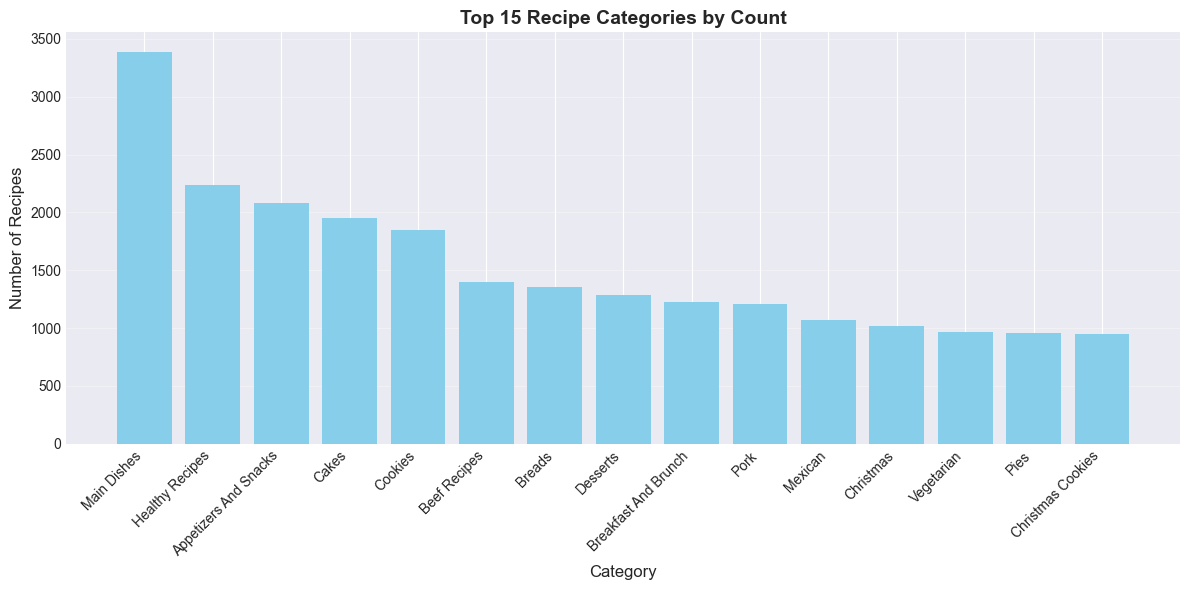

Total categories: 267


In [39]:
category_counts = con.execute("""
SELECT 
    category,
    COUNT(*) as recipe_count
FROM recipes
WHERE category IS NOT NULL
GROUP BY category
ORDER BY recipe_count DESC
LIMIT 15;
""").df()

plt.figure(figsize=(12, 6))
plt.bar(range(len(category_counts)), category_counts['recipe_count'], color='skyblue')
plt.xlabel('Category', fontsize=12)
plt.ylabel('Number of Recipes', fontsize=12)
plt.title('Top 15 Recipe Categories by Count', fontsize=14, fontweight='bold')
plt.xticks(range(len(category_counts)), category_counts['category'], rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Total categories: {len(con.execute('SELECT DISTINCT category FROM recipes WHERE category IS NOT NULL').df())}")

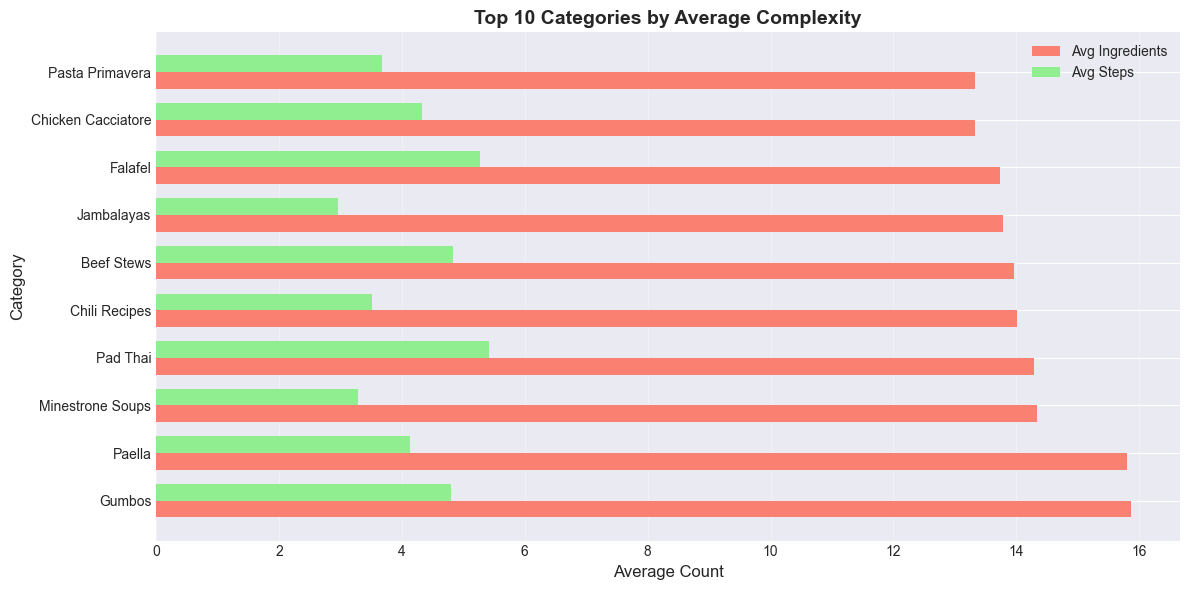

In [40]:
category_complexity = con.execute("""
SELECT 
    category,
    ROUND(AVG(num_ingredients), 2) as avg_ingredients,
    ROUND(AVG(num_steps), 2) as avg_steps,
    COUNT(*) as recipe_count
FROM recipes
WHERE category IS NOT NULL
GROUP BY category
HAVING COUNT(*) >= 10
ORDER BY avg_ingredients DESC
LIMIT 10;
""").df()

fig, ax = plt.subplots(figsize=(12, 6))
x = range(len(category_complexity))
width = 0.35

ax.barh([i - width/2 for i in x], category_complexity['avg_ingredients'], 
        width, label='Avg Ingredients', color='salmon')
ax.barh([i + width/2 for i in x], category_complexity['avg_steps'], 
        width, label='Avg Steps', color='lightgreen')

ax.set_xlabel('Average Count', fontsize=12)
ax.set_ylabel('Category', fontsize=12)
ax.set_title('Top 10 Categories by Average Complexity', fontsize=14, fontweight='bold')
ax.set_yticks(x)
ax.set_yticklabels(category_complexity['category'])
ax.legend()
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

## 5.2 Distribution by category

/var/folders/_r/r73pg99d2wjgg7ywxkxk554c0000gp/T/ipykernel_90347/3736500711.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(data_to_plot, labels=categories, patch_artist=True)


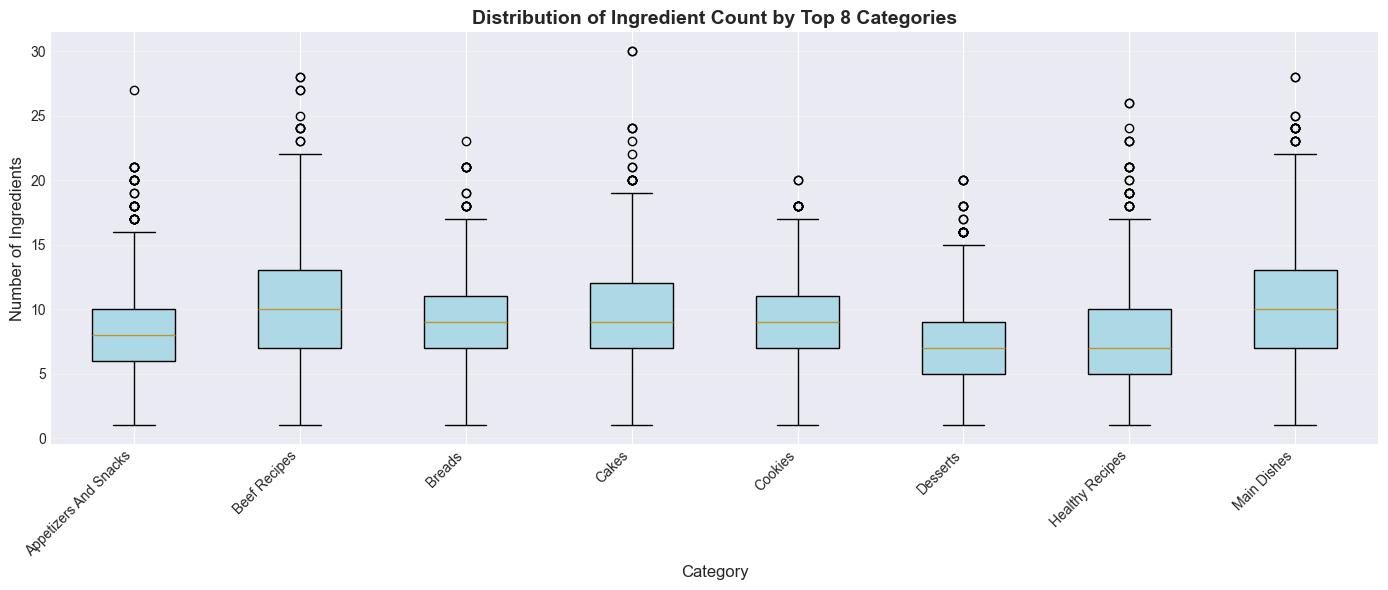

In [41]:
boxplot_data = con.execute("""
SELECT 
    category,
    num_ingredients
FROM recipes
WHERE category IN (
    SELECT category
    FROM recipes
    WHERE category IS NOT NULL
    GROUP BY category
    ORDER BY COUNT(*) DESC
    LIMIT 8
)
AND num_ingredients > 0;
""").df()

plt.figure(figsize=(14, 6))
categories = boxplot_data['category'].unique()
data_to_plot = [boxplot_data[boxplot_data['category'] == cat]['num_ingredients'].values 
                for cat in categories]

bp = plt.boxplot(data_to_plot, labels=categories, patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('lightblue')

plt.xlabel('Category', fontsize=12)
plt.ylabel('Number of Ingredients', fontsize=12)
plt.title('Distribution of Ingredient Count by Top 8 Categories', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## 5.3 Ingredient Popularity Visualization

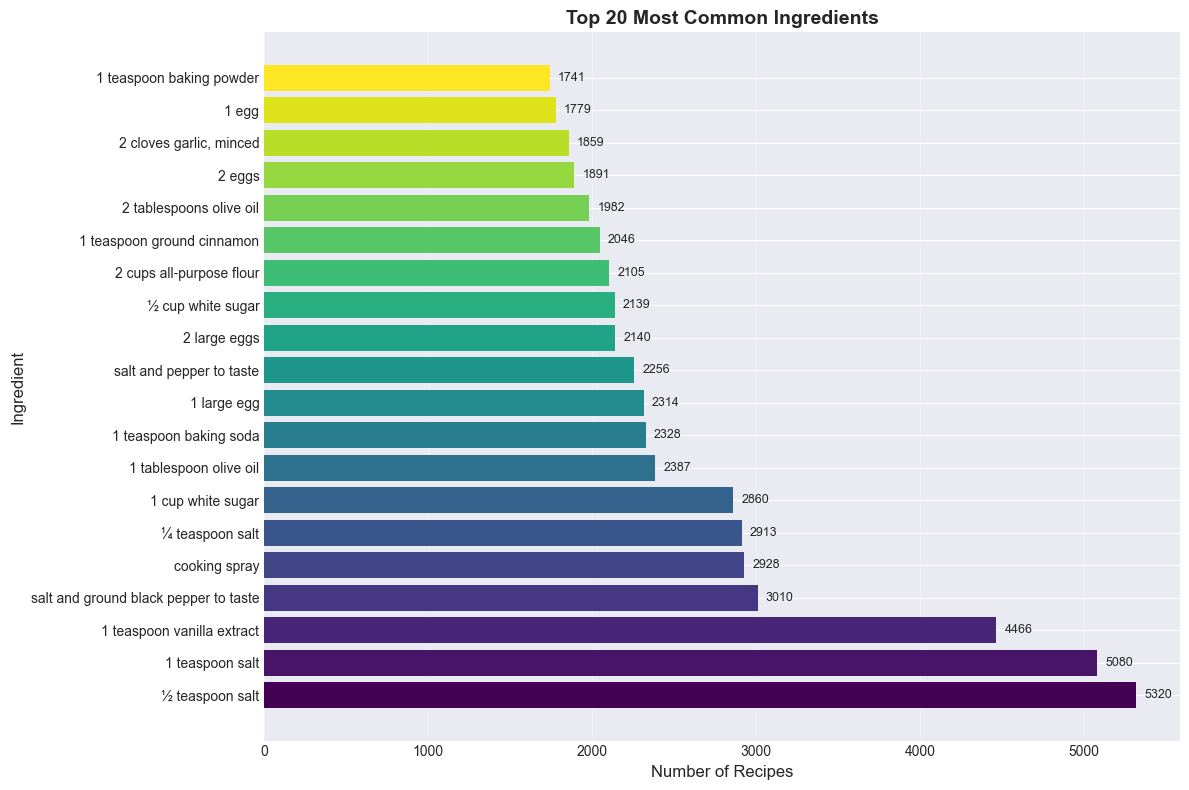

In [ ]:
top_ingredients = con.execute("""
SELECT 
    LOWER(TRIM(ingredient_text)) as ingredient,
    COUNT(DISTINCT recipe_id) as recipe_count
FROM recipes_ingredients
WHERE ingredient_text IS NOT NULL
    AND LENGTH(TRIM(ingredient_text)) > 2
GROUP BY LOWER(TRIM(ingredient_text))
ORDER BY recipe_count DESC
LIMIT 20;
""").df()

plt.figure(figsize=(12, 8))
colors = plt.cm.viridis(np.linspace(0, 1, len(top_ingredients)))
plt.barh(range(len(top_ingredients)), top_ingredients['recipe_count'], color=colors)
plt.yticks(range(len(top_ingredients)), top_ingredients['ingredient'])
plt.xlabel('Number of Recipes', fontsize=12)
plt.ylabel('Ingredient', fontsize=12)
plt.title('Top 20 Most Common Ingredients', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)

for i, v in enumerate(top_ingredients['recipe_count']):
    plt.text(v + 50, i, str(v), va='center', fontsize=9)

plt.tight_layout()
plt.show()

In [ ]:
con.close()
print("\nAnalysis complete! Database connection closed.")


Analysis complete! Database connection closed.
